## Phase 4: Temporal Generalization of AQI Classification

The objective of Phase 4 is to evaluate whether an air quality classification model trained on **past data** can generalize effectively to **future time periods**.

Unlike previous phases that relied on random train-test splits, this phase introduces a **time-aware (temporal) split**, where:
- The model is trained on earlier years
- The model is tested on later, unseen years

This setup more closely reflects real-world deployment conditions, where future air quality must be predicted using only historical observations.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/city_day_data.csv')

df.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,1/1/2015,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,1/2/2015,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,1/3/2015,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,1/4/2015,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,1/5/2015,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [ ]:
df.shape

(29531, 16)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.6+ MB


## Dataset Overview

The dataset used in Phase 4 is the same city-day air quality dataset used in previous phases.

It contains daily pollutant measurements recorded across multiple Indian cities, including particulate matter, gaseous pollutants, and volatile organic compounds (VOCs).

Key characteristics of the dataset:
- **Temporal granularity:** Daily observations
- **Spatial granularity:** City-level measurements
- **Pollutants included:** PM2.5, PM10, NO, NO₂, NOx, CO, SO₂, O₃, Benzene, Toluene
- **Target variable:** AQI_Bucket (categorical)

While the raw dataset remains unchanged, the modeling strategy in this phase differs by explicitly incorporating time into the evaluation process.


In [ ]:
df.isnull().sum()

,0
City,0
Date,0
PM2.5,4598
PM10,11140
NO,3582
NO2,3585
NOx,4185
NH3,10328
CO,2059
SO2,3854


## Feature Engineering Strategy

To maintain consistency with Phase 2 and Phase 3, pollutant features were grouped into three domain-driven indices based on chemical similarity and environmental relevance:

- **PM_Index:** Combines particulate matter indicators (PM2.5, PM10)
- **Gas_Index:** Aggregates gaseous pollutants (NO, NO₂, NOx, CO, SO₂, O₃)
- **VOC_Index:** Represents volatile organic compounds (Benzene, Toluene)

This abstraction reduces dimensionality and transforms raw pollutant measurements into higher-level indicators that capture broader pollution behavior.



## Target Variable Definition

The target variable for Phase 4 is `AQI_Bucket`, a categorical representation of air quality levels.

AQI_Bucket discretizes continuous AQI values into predefined air quality categories, such as:
- Good
- Satisfactory
- Moderate
- Poor
- Very Poor
- Severe

This formulation shifts the task from numerical prediction to **multi-class classification**, which is more suitable for public communication, health advisories, and policy-level decision-making.


In [ ]:
target = 'AQI_Bucket'

pm_pollutants = ['PM2.5', 'PM10']
gas_pollutants = ['NO', 'NO2', 'NOx', 'CO', 'SO2', 'O3']
voc_pollutants = ['Benzene', 'Toluene']

all_pollutants = pm_pollutants + gas_pollutants + voc_pollutants

In [ ]:
df_p4 = df[all_pollutants + [target]]

df_p4.head()

,PM2.5,PM10,NO,NO2,NOx,CO,SO2,O3,Benzene,Toluene,AQI_Bucket
0,NaN,NaN,0.92,18.22,17.15,0.92,27.64,133.36,0.00,0.02,NaN
1,NaN,NaN,0.97,15.69,16.46,0.97,24.55,34.06,3.68,5.50,NaN
2,NaN,NaN,17.40,19.30,29.70,17.40,29.07,30.70,6.80,16.40,NaN
3,NaN,NaN,1.70,18.48,17.97,1.70,18.59,36.08,4.43,10.14,NaN
4,NaN,NaN,22.10,21.42,37.76,22.10,39.33,39.31,7.01,18.89,NaN


In [ ]:
df_p4.isnull().sum()

,0
PM2.5,4598
PM10,11140
NO,3582
NO2,3585
NOx,4185
CO,2059
SO2,3854
O3,4022
Benzene,5623
Toluene,8041


In [ ]:
df_p4 = df_p4.dropna(subset=[target])

df_p4.shape

(24850, 11)

In [ ]:
for col in all_pollutants:
    median_value = df_p4[col].median()
    df_p4[col] = df_p4[col].fillna(median_value)

In [ ]:
df_p4.isnull().sum()

,0
PM2.5,0
PM10,0
NO,0
NO2,0
NOx,0
CO,0
SO2,0
O3,0
Benzene,0
Toluene,0


## Data Cleaning and Preprocessing

Missing values were handled after feature selection to ensure consistency across engineered features.

The following steps were applied:
- Rows with missing target labels (`AQI_Bucket`) were removed
- Missing pollutant values were imputed using **median imputation**, which is robust to skewed distributions and outliers

Since AQI_Bucket is categorical, no transformation or scaling was applied to the target variable.


## Feature Scaling and Index Construction

Before constructing pollutant indices, individual pollutant features were standardized using **Z-score normalization**.

This ensures:
- Equal contribution of pollutants within the same index
- Prevention of scale dominance (e.g., PM10 overpowering PM2.5)

After normalization:
- PM_Index, Gas_Index, and VOC_Index were computed as the **mean** of their respective normalized pollutant groups

No further normalization was applied after index construction.


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_scaled = df_p4.copy()

df_scaled[all_pollutants] = scaler.fit_transform(df_p4[all_pollutants])

In [ ]:
df_scaled['PM_Index'] = df_scaled[pm_pollutants].mean(axis=1)

df_scaled['Gas_Index'] = df_scaled[gas_pollutants].mean(axis=1)

df_scaled['VOC_Index'] = df_scaled[voc_pollutants].mean(axis=1)

In [ ]:
features_p2 = ['PM_Index', 'Gas_Index', 'VOC_Index']

X = df_scaled[features_p2]
y = df_scaled[target]

X.head(), y.head()

(    PM_Index  Gas_Index  VOC_Index
 28  0.025449   0.576848  -0.325674
 29 -0.000964   1.115187  -0.325002
 30  0.116887   1.830487  -0.318006
 31  0.449808   2.679544  -0.311813
 32  0.789712   2.754626  -0.309254,
 28         Poor
 29    Very Poor
 30       Severe
 31       Severe
 32       Severe
 Name: AQI_Bucket, dtype: object)

## Temporal Train-Test Split

To evaluate temporal generalization, the dataset was split based on **time rather than randomly**.

- Data from **earlier years (≤ 2018)** was used for training
- Data from **later years (≥ 2019)** was reserved for testing

This approach prevents information leakage from future data and simulates real-world forecasting conditions, where future air quality must be inferred from historical patterns.


In [ ]:
df_scaled['Date'] = pd.to_datetime(df['Date'])
df_scaled['Year'] = df_scaled['Date'].dt.year

df_scaled.groupby('Year').size()


,0
Year,
2015,1827
2016,2573
2017,3234
2018,5724
2019,7071
2020,4421


In [ ]:
tdf = df_scaled[df_scaled['Year'] <= 2018]
tedf  = df_scaled[df_scaled['Year'] >= 2019]

tdf.shape, tedf.shape


((13358, 16), (11492, 16))

In [ ]:
tdf.columns


Index(['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO', 'SO2', 'O3', 'Benzene',
       'Toluene', 'AQI_Bucket', 'PM_Index', 'Gas_Index', 'VOC_Index', 'Date',
       'Year'],
      dtype='object')

In [ ]:
features = ['PM_Index', 'Gas_Index', 'VOC_Index']
target = 'AQI_Bucket'

X_train = tdf[features]
y_train = tdf[target]

X_test = tedf[features]
y_test = tedf[target]


In [ ]:
y_train.value_counts(normalize=True) * 100
y_test.value_counts(normalize=True) * 100


,proportion
AQI_Bucket,
Satisfactory,39.383919
Moderate,34.589279
Poor,9.058475
Good,8.188305
Very Poor,5.447268
Severe,3.332753


## Class Distribution Analysis

The distribution of AQI categories was examined separately for training and testing sets.

This analysis revealed:
- Significant class imbalance across AQI categories
- Dominance of moderate and satisfactory air quality classes
- Underrepresentation of extreme pollution categories (Very Poor, Severe)

To address this imbalance during training, class-weighted learning was employed.


## Model: Random Forest Classifier (Temporal Evaluation)

A Random Forest classifier was used to evaluate temporal generalization performance.

Random Forest was selected because:
- It captures non-linear relationships between pollution indices
- It is robust to noise and outliers
- It reduces overfitting through ensemble averaging

Class weights were set to **balanced** to mitigate the effects of class imbalance.


In [ ]:
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    min_samples_leaf=20,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=12,
                       min_samples_leaf=20, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [ ]:
y_pred_time = rf_clf.predict(X_test)

acc_time = accuracy_score(y_test, y_pred_time)
f1_time = f1_score(y_test, y_pred_time, average='macro')

acc_time, f1_time


(0.5910198398886182, 0.5113952605185608)

## Model Performance on Future Data

The trained model was evaluated on data from future years using:
- Accuracy
- Macro-averaged F1 score
- Confusion matrix
- Classification report

These metrics assess not only overall performance but also the model’s ability to generalize across all AQI categories.


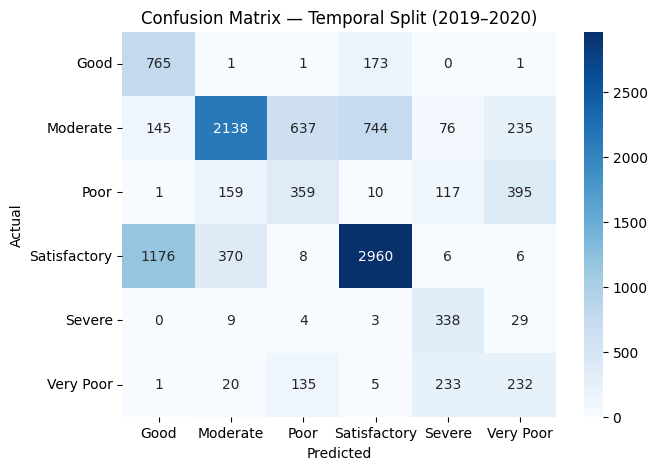

In [ ]:
cm_time = confusion_matrix(y_test, y_pred_time)

plt.figure(figsize=(7,5))
sns.heatmap(
    cm_time,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=rf_clf.classes_,
    yticklabels=rf_clf.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Temporal Split (2019–2020)")
plt.show()

## Confusion Matrix Analysis

The confusion matrix reveals how predictions on future data align with actual AQI categories.

Key observations:
- Strong performance for common AQI categories such as Satisfactory and Moderate
- Increased misclassification among neighboring AQI levels
- Reduced recall for rare and extreme pollution categories

This indicates that while the model generalizes reasonably well, uncertainty increases for high-severity pollution events.


In [ ]:
print(classification_report(y_test, y_pred_time))


              precision    recall  f1-score   support

        Good       0.37      0.81      0.51       941
    Moderate       0.79      0.54      0.64      3975
        Poor       0.31      0.34      0.33      1041
Satisfactory       0.76      0.65      0.70      4526
      Severe       0.44      0.88      0.59       383
   Very Poor       0.26      0.37      0.30       626

    accuracy                           0.59     11492
   macro avg       0.49      0.60      0.51     11492
weighted avg       0.66      0.59      0.61     11492



## Classification Report Analysis

The classification report highlights variation in precision, recall, and F1-score across AQI categories.

Notable patterns include:
- Higher scores for frequently occurring classes
- Lower recall for underrepresented extreme AQI buckets
- Moderate macro-averaged performance, reflecting balanced but imperfect generalization

These results are consistent with the inherent difficulty of predicting rare air quality events using historical data alone.


## Assumptions and Limitations

### Assumptions
- Historical pollutant patterns contain sufficient information to predict future AQI categories
- Engineered indices adequately summarize pollutant behavior
- Temporal stationarity holds to a reasonable extent

### Limitations
- Sudden environmental or policy changes are not captured
- City-specific geographic effects are not explicitly modeled
- Extreme pollution events remain difficult to predict accurately
- Temporal drift and long-term climate effects are not fully addressed

These limitations highlight the challenges of deploying air quality models in evolving real-world environments.


## Conclusion

Phase 4 extends the air quality modeling pipeline by introducing **temporal generalization**, a critical requirement for real-world deployment.

By training on historical data and testing on future periods, this phase demonstrates:
- The feasibility of predicting AQI categories across time
- The impact of temporal drift on model performance
- The persistent difficulty of forecasting extreme pollution events

Overall, Phase 4 confirms that while engineered features and ensemble models generalize reasonably well over time, further improvements—such as temporal modeling and city-aware learning—are necessary for robust long-term air quality forecasting.
